## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [79]:
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as scs
from scipy.signal import find_peaks

import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [80]:
def adfuller_stats(values):
   dftest = sm.tsa.stattools.adfuller(values)
   dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
   for key,value in dftest[4].items():
     dfoutput['Critical Value (%s)'%key] = value
   return dfoutput

def rolling_means_plt(timeseries, window):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

def tsplot_plt(y, lags=30, figsize=(12, 7), style='bmh'):
    """
    plot: Auto-Correlation graph, Partial AutoCorrelation graph 
    with 
    Time Series Analysis
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


def rmse_error(y_true, y_pred):
  return mean_squared_error(y_true, y_pred, squared=False)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    if plot_intervals:
        tscv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    mape = mean_absolute_percentage_error(prediction, y_test)
    rmse = rmse_error(prediction, y_test)
    plt.title(f"MAPE {mape:.2f}%, RMSE {rmse:.2f}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
def plotCoefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

# 1. Preparation

In [81]:
pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv").head()

datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

In [82]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=['datetime'], parse_dates=['datetime'])

In [83]:
df = df.resample('1h').sum().sort_index()

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [85]:
df.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

In [86]:
target = "num_orders"

# 2. Analysis

In [87]:
def prepare_data(df, target="num_orders", window_size=6, n_lag=25):
  data = df.copy()
  data['rolling_mean'] = data[target].shift().rolling(window_size).mean()
  for lag in range(1, n_lag + 1):
    data["lag_{}".format(lag)] = data[target].shift(lag)#, fill_value=0)
  data['dayofweek'] = data.index.dayofweek
  data['month'] = data.index.month
  data['week'] = data.index.week
  data['dayofmonth'] = data.index.day
  data['hour'] = data.index.hour
  data['is_weekend'] = data.dayofweek.isin([5,6])*1
  data = data.dropna()
  return data

In [88]:
data = prepare_data(df)

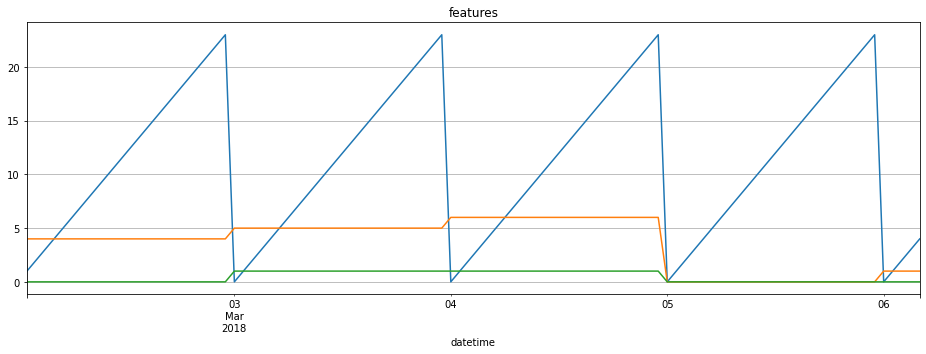

In [89]:
plt.figure(figsize=(16, 5))
plt.title("features")
data[:100].hour.plot()
data[:100].dayofweek.plot()
data[:100].is_weekend.plot()
plt.grid(True);

 Augmented Dickey-Fuller test determine if the series is stationary, let's test it and check p-value

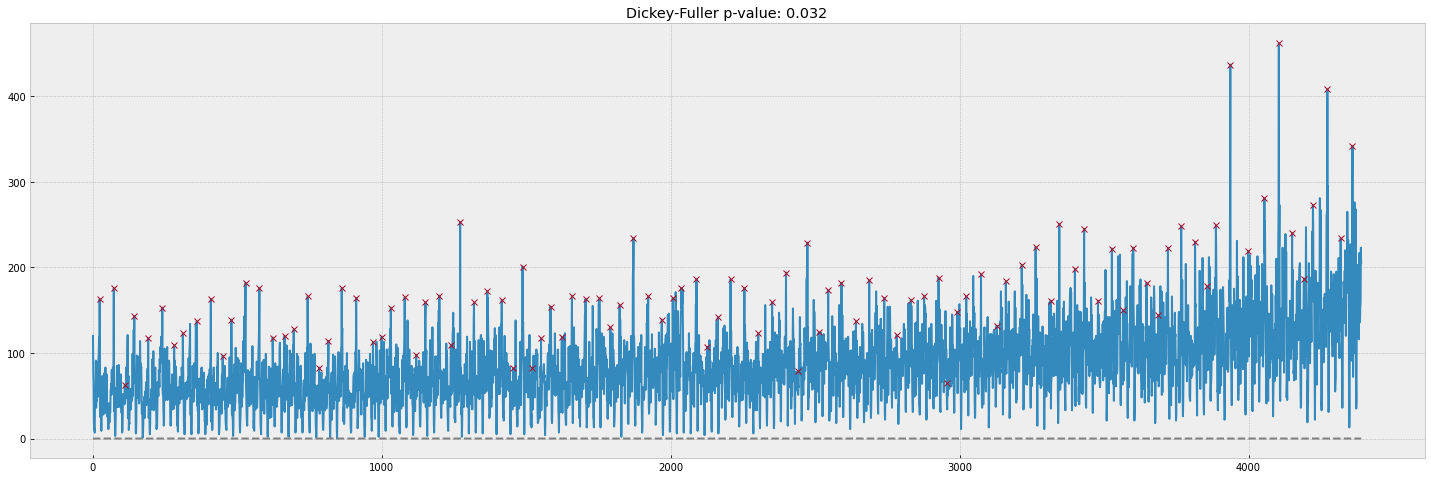

In [90]:
with plt.style.context('bmh'):  
    x = data["num_orders"].values
    peaks, _ = find_peaks(x, distance=30)
    plt.figure(figsize=(25, 8))
    plt.plot(x, label='hour')
    plt.plot(peaks, x[peaks], "x")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(data["num_orders"].values)[1], 3)))  
    plt.grid(True)

In [91]:
adfuller_stats(data["num_orders"].values)

Test Statistic                   -3.028709
p-value                           0.032299
#Lags Used                       30.000000
Number of Observations Used    4360.000000
Critical Value (1%)              -3.431851
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64

let's assuming significance Î±=0.01, therefore we could not reject the null hypothesis, and classify this as stationary


let's plot rolling average (and std)

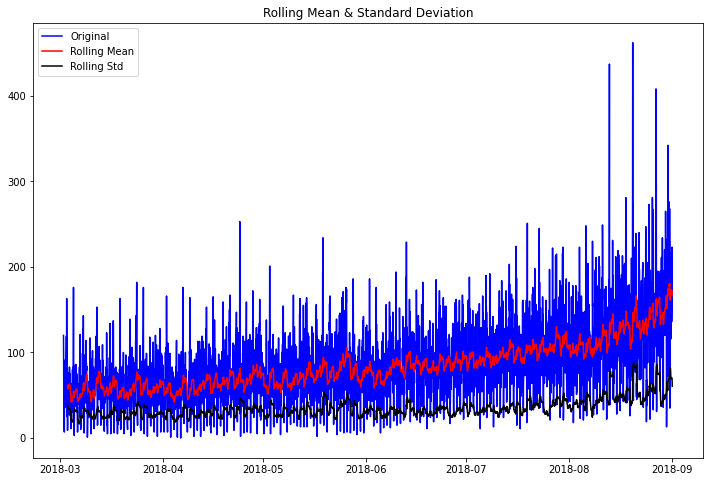

In [92]:
rolling_means_plt(data["num_orders"], window=30)

let's try do stationary model

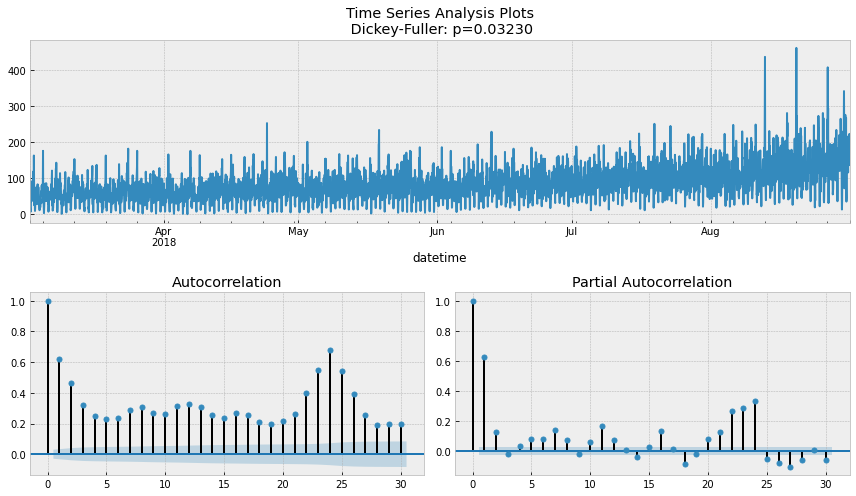

In [93]:
tsplot_plt(data["num_orders"]) 

let's plot autocorellation graphs

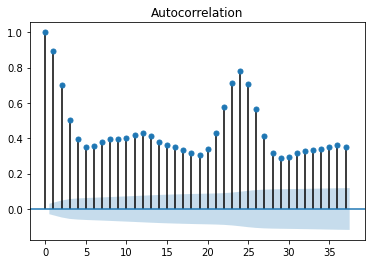

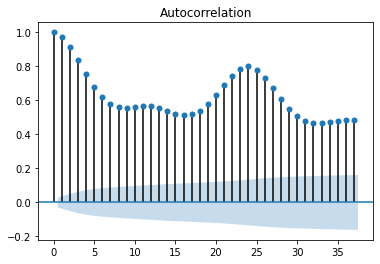

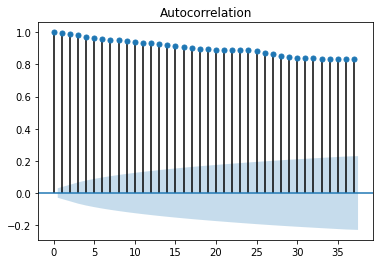

In [94]:
plot_acf(data["num_orders"].rolling(window=3).mean().dropna())
plot_acf(data["num_orders"].rolling(window=7).mean().dropna())
plot_acf(data["num_orders"].rolling(window=30).mean().dropna())
plt.show()

as we could see , we have seasonality, which we have to deal with prior to modeling. let's take the a simple subtraction of the series from itself with a lag that equals the seasonal period

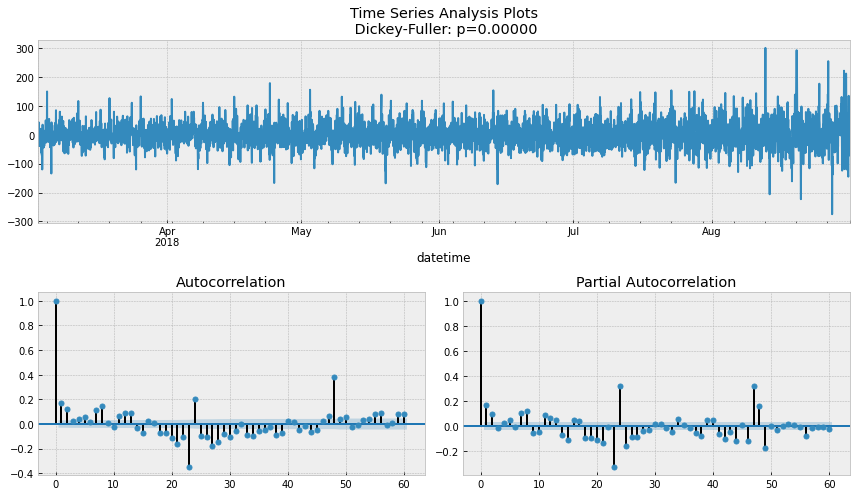

In [95]:
ads_diff = data["num_orders"] - data["num_orders"].shift(23)
tsplot_plt(ads_diff[23:], lags=60)

oscillating around zero, The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. we can 
start modeling

let's see seasonality

for a week

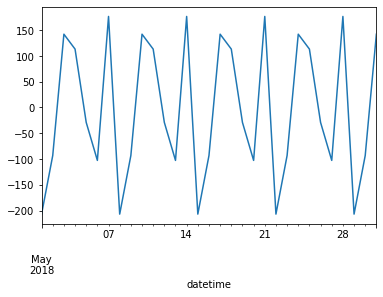

In [96]:
seasonal_decompose(data['2018-05-01':'2018-05-31'].resample('1D').sum().loc[:, target]).seasonal.plot()

for a day

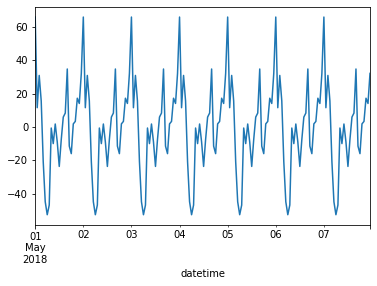

In [97]:
seasonal_decompose(data['2018-05-01':'2018-05-07'].loc[:, 'num_orders']).seasonal.plot(ax=plt.gca())

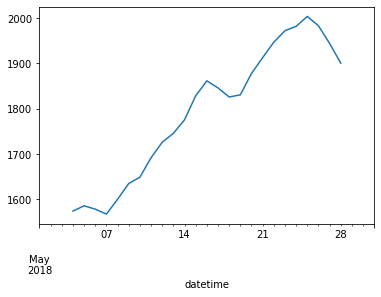

In [98]:
seasonal_decompose(data['2018-05-01':'2018-05-31'].resample('1D').sum().loc[:, target]).trend.plot()

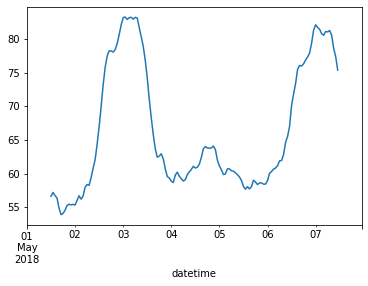

In [99]:
seasonal_decompose(data['2018-05-01':'2018-05-07'].loc[:, 'num_orders']).trend.plot(ax=plt.gca())

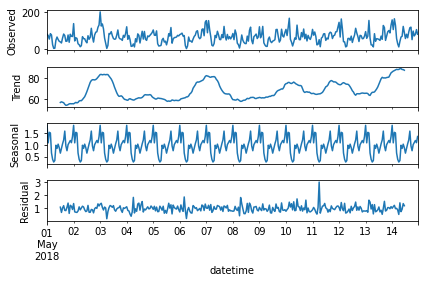

In [100]:
result = seasonal_decompose(data['2018-05-01':'2018-05-14'].loc[:, 'num_orders'], model='multiplicative')
result.plot()
plt.show()

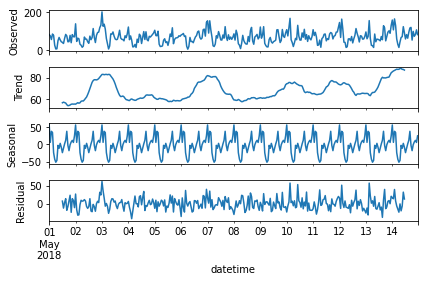

In [101]:
result = seasonal_decompose(data['2018-05-01':'2018-05-14'].loc[:, 'num_orders'], model='additive')
result.plot()
plt.show()

as we could see,  the trend and seasonality extracted from the series does seem reasonable. according to residuals, we could see periods of high variability in the early and later periods(days) of the series

# 3. Training

# 4. Testing

In [102]:
target = "num_orders"
features = set(data.columns)-set([target])

In [103]:
X, y = data[features], data[target]

In [104]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], shuffle=False, test_size=0.1)

In [105]:
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-02 01:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


### LinearRegression

In [106]:
rows = []
for i in range(1,X_train.shape[1]):
    lr = LinearRegression()
    lr.fit(X_train.iloc[:, :i], y_train)
    y_pred = lr.predict(X_test.iloc[:, :i])
    rows.append(dict(shifted=i, score=1-lr.score(X_test.iloc[:, :i], y_test), MSE=mean_squared_error(y_test, y_pred), RMSE=rmse_error(y_test, y_pred)))
stats_df = pd.DataFrame(rows)
stats_df

shifted     score          MSE       RMSE
0         1  1.914416  6580.954970  81.123085
1         2  1.072000  3685.083474  60.704888
2         3  1.043043  3585.543253  59.879406
3         4  1.048230  3603.371656  60.028091
4         5  1.021863  3512.733505  59.268318
5         6  1.007090  3461.951572  58.838351
6         7  0.811016  2787.929128  52.800844
7         8  0.796113  2736.699648  52.313475
8         9  0.794689  2731.804424  52.266666
9        10  0.813675  2797.072981  52.887361
10       11  0.834893  2870.010653  53.572480
11       12  0.821018  2822.312444  53.125441
12       13  0.842358  2895.671095  53.811440
13       14  0.683921  2351.030510  48.487426
14       15  0.686056  2358.369685  48.563049
15       16  0.689214  2369.227753  48.674714
16       17  0.675934  2323.574530  48.203470
17       18  0.671379  2307.918057  48.040796
18       19  0.672032  2310.161780  48.064142
19       20  0.664633  2284.726351  47.798811
20       21  0.667009  2292.896267  47.884196
21       22  0.666917  2292.580462  47.880899
22       23  0.673421  2314.937429  48.113797
23       24  0.634712  2181.871434  46.710507
24       25  0.638770  2195.820610  46.859584
25       26  0.632126  2172.981664  46.615251
26       27  0.629708  2164.671756  46.526033
27       28  0.623949  2144.873144  46.312775
28       29  0.622045  2138.327917  46.242058
29       30  0.610649  2099.154475  45.816531
30       31  0.610649  2099.154475  45.816531

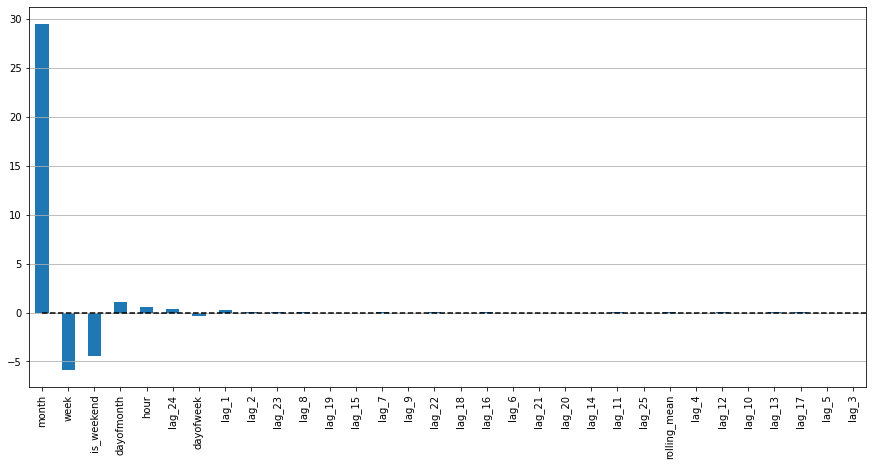

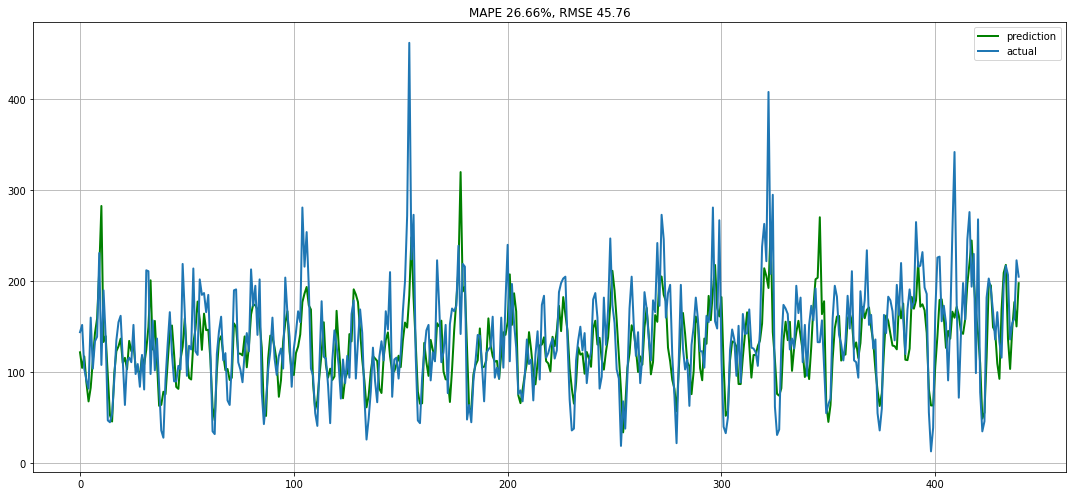

In [107]:
lr = LinearRegression()
lr.fit(X_train, y_train)
plotCoefficients(lr)
plotModelResults(lr, X_train, X_test, y_train, y_test)

In [108]:
stats_df.iloc[stats_df["RMSE"].argmin()]

shifted      31.000000
score         0.610649
MSE        2099.154475
RMSE         45.816531
Name: 30, dtype: float64

In [109]:
best_shifted = int(stats_df.iloc[stats_df["RMSE"].argmin()]["shifted"])
best_shifted

31

### RandomForestRegressor

In [110]:
model = RandomForestRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

print(rmse_error(y_pred, y_test))

41.949797404430065


In [111]:
param_grid ={'n_estimators': range(50, 60, 5),
            'max_depth': range(8,16,4),
            'min_samples_split': range(10,40,10),
            'max_features':range(3,10,2)}

lets use mae insted of rmse for avoiding negative results as score

In [112]:
rmse_scorer = make_scorer(rmse_error, greater_is_better=False)

In [113]:
model = RandomForestRegressor(n_estimators=100)
tscv = TimeSeriesSplit(n_splits=5)
clf = GridSearchCV(model, scoring=rmse_scorer, param_grid=param_grid, n_jobs=4, cv=tscv).fit(X_train, y_train)
best_params = clf.best_params_
print(clf.best_score_)

-25.02419593334649


In [114]:
model = RandomForestRegressor(**best_params).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(rmse_error(y_pred, y_test))

41.00353525422929


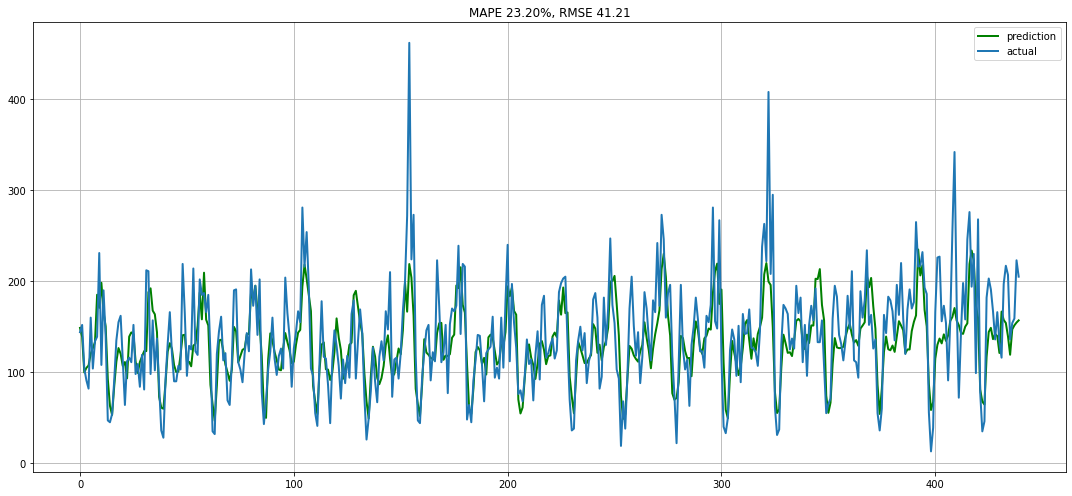

In [115]:
model = RandomForestRegressor(**best_params).fit(X_train, y_train)
plotModelResults(model, X_train, X_test, y_train, y_test)

In [116]:
best_params

{'max_depth': 12,
 'max_features': 9,
 'min_samples_split': 10,
 'n_estimators': 55}

# Summary

we found that our model is non stationary, we built linear model and tree based model and found best result for tree based model and with rmse less than 41 which is enough. also we checked daily changes, week changes and found drift around 22-23 days

## Additional model: LSTM

I was curious about checking some simple LSTM model for the case

In [197]:
import torch
import torch.nn as nn

In [198]:
use_gpu = lambda x=True: torch.set_default_tensor_type(torch.cuda.FloatTensor 
                                             if torch.cuda.is_available() and x 
                                             else torch.FloatTensor)

In [199]:
use_gpu()

In [200]:
device = torch.device("cuda")

In [201]:
train_data = torch.FloatTensor(X_train.values).to(device)
test_data = torch.FloatTensor(X_test.values).to(device)

In [207]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=150, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=1, dropout=0.3)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        
     
    def to(self, device):
        super(LSTM, self).to(device)
        self.lstm = self.lstm.to(device)
        self.linear = self.linear.to(device)
        self.hidden_cell = tuple(map(lambda t: t.to(device), self.hidden_cell))
        self.device = device
        return self

    def reset_hidden_state(self):
        if self.device is not None:
            self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(self.device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(self.device))
        else:
            self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [203]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [208]:
model = LSTM().to(device)
loss_function = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [209]:
epochs = 150
model.train()
for i in range(epochs):
    for seq, labels in zip(train_data, y_train):
        optimizer.zero_grad()
        model.reset_hidden_state()
        y_pred = model(seq)
        label = torch.FloatTensor([labels]).to(device)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()

    if i%25 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 71.47477722
epoch:  25 loss: 67.15249634
epoch:  50 loss: 62.23415375
epoch:  75 loss: 58.32328796
epoch: 100 loss: 55.68744659
epoch: 125 loss: 46.82424927
epoch: 149 loss: 49.5469207764


In [210]:
model.eval()
y_pred = []
for i in range(len(test_inout_seq)):
  with torch.no_grad():
    model.reset_hidden_state()
    y_pred.append(model(test_inout_seq[i]).item())
y_pred = np.array(y_pred)
print(rmse_error(y_pred, y_test))

45.49893237334938


as we see, some simple LSTM model gave us really nice result,  less than 48

# References:

ODS ML time series topic 9:
* [part 1](https://mlcourse.ai/articles/topic9-part1-time-series/)
* [part 2](https://mlcourse.ai/articles/topic9-part2-prophet/)



# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48